# Adversarial Robustness with Error Correcting Codes
## (Never use Softmax again)

In this example we will show how using error correcting codes to convert model logits to probabilities can drastically reduce model overfitting while simultaneously increasing model robustness against adversarial attacks. In other words, why you should never use a softmax layer again. This phenomena was first publicized by the US Army in a [2019 Neurips Paper](https://papers.nips.cc/paper/9070-error-correcting-output-codes-improve-probability-estimation-and-adversarial-robustness-of-deep-neural-networks.pdf). For background on adversarial attacks, and on the attack type we will be demonstrating here, check out our [FGSM](../fgsm/fgsm.ipynb) apphub example. Note that in this apphub we will not be training against adversarial samples, but only performing adversarial attacks during evaluation to see how different models fair against them.

## Imports

In [1]:
import math
import tempfile

from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.python.keras.models import Model

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import cifar10
from fastestimator.layers.tensorflow import HadamardCode
from fastestimator.op.numpyop.univariate import Normalize
from fastestimator.op.tensorop import Average
from fastestimator.op.tensorop.gradient import FGSM, Watch
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import EarlyStopping
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

In [2]:
# training parameters
epsilon=0.04  # The strength of the adversarial attack
epochs=60
batch_size=50
log_steps=500
max_train_steps_per_epoch=None
max_eval_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

## Getting the Data
For these experiments we will be using the CIFAR-10 Dataset

In [3]:
train_data, eval_data = cifar10.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))])

## Defining an Estimator
In this apphub we will be comparing three very similar models, all using the same training and evaluation routines. Hence a function to generate the estimators:

In [4]:
def get_estimator(model):
    network = fe.Network(ops=[
        Watch(inputs="x", mode=('eval', 'test')),
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="base_ce"),
        UpdateOp(model=model, loss_name="base_ce"),
        FGSM(data="x", loss="base_ce", outputs="x_adverse", epsilon=epsilon, mode=('eval', 'test')),
        ModelOp(model=model, inputs="x_adverse", outputs="y_pred_adv", mode=('eval', 'test')),
        CrossEntropy(inputs=("y_pred_adv", "y"), outputs="adv_ce", mode=('eval', 'test'))
    ])
    traces = [
        Accuracy(true_key="y", pred_key="y_pred", output_name="base accuracy"),
        Accuracy(true_key="y", pred_key="y_pred_adv", output_name="adversarial accuracy"),
        BestModelSaver(model=model, save_dir=save_dir, metric="base_ce", save_best_mode="min", load_best_final=True),
        EarlyStopping(monitor="base_ce", patience=10)
    ]
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces,
                             log_steps=log_steps,
                             max_train_steps_per_epoch=max_train_steps_per_epoch,
                             max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                             monitor_names=["adv_ce"])
    return estimator

## The Models
### 1 - A LeNet model with Softmax

In [5]:
softmax_model = fe.build(model_fn=lambda:LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam", model_name='softmax')

### 2 - A LeNet model with Error Correcting Codes

In [6]:
def EccLeNet(input_shape=(32, 32, 3), classes=10):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(HadamardCode(classes))  # Note that this is the only difference between this model and the FE LeNet implementation
    return model

In [7]:
ecc_model = fe.build(model_fn=EccLeNet, optimizer_fn="adam", model_name='ecc')

### 3 - A LeNet model using ECC and multiple feature heads
While it is common practice to follow the feature extraction layers of convolution networks with several fully connected layers in order to perform classification, this can lead to the final logits being interdependent which can actually reduce the robustness of the network. One way around this is to divide your classification layers into multiple smaller independent units:

In [8]:
def HydraEccLeNet(input_shape=(32, 32, 3), classes=10):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    flat = Flatten()(conv3)
    # Create multiple heads
    n_heads = 4
    heads = [Dense(16, activation='relu')(flat) for _ in range(n_heads)]
    outputs = HadamardCode(classes)(heads)
    return Model(inputs=inputs, outputs=outputs)

In [9]:
hydra_model = fe.build(model_fn=HydraEccLeNet, optimizer_fn="adam", model_name='hydra_ecc')

## The Experiments
Let's get Estimators for each of these models and compare them:

In [10]:
softmax_estimator = get_estimator(softmax_model)
ecc_estimator = get_estimator(ecc_model)
hydra_estimator = get_estimator(hydra_model)

In [11]:
softmax_estimator.fit('Softmax')
softmax_results = softmax_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 
FastEstimator-Train: step: 1; base_ce: 2.3754928; 
FastEstimator-Train: step: 500; base_ce: 1.2483782; steps/sec: 33.49; 
FastEstimator-Train: step: 1000; base_ce: 1.3786774; steps/sec: 24.76; 
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 36.88 sec; 
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmp__tav_q_/softmax_best_base_ce.h5
FastEstimator-Eval: step: 1000; epoch: 1; base_ce: 1.1597806; adv_ce: 1.9426155; base accuracy: 0.590

In [12]:
ecc_estimator.fit('ECC')
ecc_results = ecc_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 
FastEstimator-Train: step: 1; base_ce: 2.2948906; 
FastEstimator-Train: step: 500; base_ce: 1.8532416; steps/sec: 30.21; 
FastEstimator-Train: step: 1000; base_ce: 1.7478514; steps/sec: 31.69; 
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 33.4 sec; 
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmp__tav_q_/ecc_best_base_ce.h5
FastEstimator-Eval: step: 1000; epoch: 1; base_ce: 1.7138911; adv_ce: 2.1511297; base accuracy: 0.496; adv

In [13]:
hydra_estimator.fit('Hydra')
hydra_results = hydra_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 
FastEstimator-Train: step: 1; base_ce: 2.3076158; 
FastEstimator-Train: step: 500; base_ce: 1.7894692; steps/sec: 39.9; 
FastEstimator-Train: step: 1000; base_ce: 1.6115338; steps/sec: 41.67; 
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 25.65 sec; 
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmp__tav_q_/hydra_ecc_best_base_ce.h5
FastEstimator-Eval: step: 1000; epoch: 1; base_ce: 1.772432; adv_ce: 2.2166047; base accuracy: 0.456

## Comparing the Results

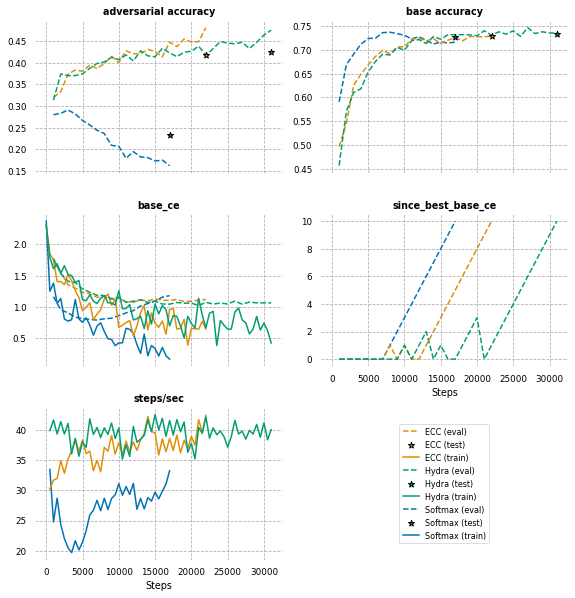

In [14]:
logs = visualize_logs(experiments=[softmax_results, ecc_results, hydra_results], ignore_metrics={'ecc_lr', 'hydra_ecc_lr', 'softmax_lr', 'logging_interval', 'num_device', 'epoch_time', 'min_base_ce', 'adv_ce', 'total_time'})

As you can see, the conventional network using softmax to convert logits to class probabilities actually gets more and more vulnerable to adversarial attacks as training progresses. It also quickly overfits to the data, reaching an optimal performance around epoch 7. By simply switching the softmax layer for an error-correcting-code, the network is able to train for around 16 epochs before starting to cap out, and even then continuing to train it results in better and better adversarial performance. Creating a multi-headed ecc output layer allows still more training and higher peak performances. If you were to run the experiment out to 160 epochs you would find that the adversarial accuracy can reach between 60-70% with only a slight accuracy degradation on clean samples (performance still above 70%). This is significantly better performance than networks trained specifically to combat this attack, shown in the [FGSM](../fgsm/fgsm.ipynb) notebook. Note also that their is virtually no additional cost to training using ECC as opposed to softmax in terms of steps/sec. This is a big benefit over FGSM, where the training time for each step is doubled. With these benefits in mind, you may want to consider never using softmax again.